# Using wandb to track stats

In [1]:
!pip install wandb -q

In [2]:
import wandb
wandb.login()


ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: trhgquan (khongsomeo). Use `wandb login --relogin` to force relogin


True

In [3]:
%env WANDB_PROJECT=XLM-roberta-classification

env: WANDB_PROJECT=XLM-roberta-classification


# Data downloader


In [4]:
!pip install tokenizers -q
!pip install transformers -q
!pip install datasets -q
!pip install evaluate -q

In [5]:
from datasets import load_dataset
from datasets import DatasetDict

train_dataset = load_dataset("trec", split = "train")
test_dataset = load_dataset("trec", split = "test")

Split the train into train and dev

In [6]:
train, dev = train_dataset.train_test_split(
    test_size = .2,
    seed = 42,
    stratify_by_column = "coarse_label"
).values()

In [7]:
train

Dataset({
    features: ['text', 'coarse_label', 'fine_label'],
    num_rows: 4361
})

In [8]:
dev

Dataset({
    features: ['text', 'coarse_label', 'fine_label'],
    num_rows: 1091
})

In [9]:
test_dataset

Dataset({
    features: ['text', 'coarse_label', 'fine_label'],
    num_rows: 500
})

In [10]:
dataset = DatasetDict({
    "train" : train,
    "dev" : dev,
    "test" : test_dataset
})

In [11]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'coarse_label', 'fine_label'],
        num_rows: 4361
    })
    dev: Dataset({
        features: ['text', 'coarse_label', 'fine_label'],
        num_rows: 1091
    })
    test: Dataset({
        features: ['text', 'coarse_label', 'fine_label'],
        num_rows: 500
    })
})

In [12]:
num_labels = len(dataset["train"].features["coarse_label"].names)

In [13]:
num_labels

6

# Preprocessing

In [14]:
from transformers import AutoTokenizer

In [15]:
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base", use_fast = True)

In [16]:
tokenizer(dataset["train"][0]["text"])

{'input_ids': [0, 15757, 70, 53702, 450, 83, 65903, 48141, 390, 10, 48748, 70615, 6, 5, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [17]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation = True)

In [18]:
tokenized_dataset = dataset.map(preprocess_function, batched = True, remove_columns = ["fine_label"])

  0%|          | 0/2 [00:00<?, ?ba/s]

Rename the label column to fit the concept

In [19]:
tokenized_dataset = tokenized_dataset.rename_column("coarse_label", "labels")

In [20]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 4361
    })
    dev: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 1091
    })
    test: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 500
    })
})

# Finetuning XLM-roberta for text classification

In [21]:
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import EarlyStoppingCallback, IntervalStrategy

In [22]:
model = AutoModelForSequenceClassification.from_pretrained("xlm-roberta-base", num_labels = num_labels)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense

In [23]:
batch_size = 16
learning_rate = 2e-5
weight_decay = .01
num_train_epochs = 10
eval_steps = 100
logging_steps = len(tokenized_dataset["train"]) // batch_size
early_stopping_patience = 3

In [24]:
args = TrainingArguments(
    "/saved",
    evaluation_strategy = IntervalStrategy.STEPS,
    # save_strategy = IntervalStrategy.STEPS,

    eval_steps = eval_steps,
    logging_steps = logging_steps,
    
    learning_rate = learning_rate,
    
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    
    num_train_epochs = num_train_epochs,
    
    weight_decay = weight_decay,
    save_total_limit = 3,
    load_best_model_at_end = True,
    metric_for_best_model = "accuracy",
    report_to = "wandb"
)

In [25]:
import evaluate
import numpy as np

In [26]:
metric = evaluate.load("accuracy")

In [27]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    predictions = np.argmax(predictions, axis = 1)

    return metric.compute(predictions = predictions, references = labels)

In [28]:
trainer = Trainer(
    model,
    args,
    train_dataset = tokenized_dataset["train"],
    eval_dataset = tokenized_dataset["dev"],
    tokenizer = tokenizer,
    compute_metrics = compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience = early_stopping_patience)]
)

In [29]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy
100,No log,0.744420,0.771769
200,No log,0.369847,0.897342
300,0.869700,0.337204,0.906508
400,0.869700,0.355382,0.908341
500,0.869700,0.272649,0.932172
600,0.313600,0.334638,0.925756
700,0.313600,0.313976,0.933089
800,0.313600,0.281515,0.946838
900,0.169700,0.293330,0.947754
1000,0.169700,0.302900,0.944088


The following columns in the evaluation set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `XLMRobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1091
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `XLMRobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1091
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from /saved/checkpoint-2000 (score: 0.9560036663611365).


TrainOutput(global_step=2300, training_loss=0.20007468804069187, metrics={'train_runtime': 546.3131, 'train_samples_per_second': 79.826, 'train_steps_per_second': 4.997, 'total_flos': 487244186874612.0, 'train_loss': 0.20007468804069187, 'epoch': 8.42})

# Evaluation

In [30]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `XLMRobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1091
  Batch size = 16


{'eval_loss': 0.2867498993873596,
 'eval_accuracy': 0.9560036663611365,
 'eval_runtime': 1.8415,
 'eval_samples_per_second': 592.468,
 'eval_steps_per_second': 37.47,
 'epoch': 8.42}

In [31]:
predictions, labels, _ = trainer.predict(tokenized_dataset["test"])

predictions = np.argmax(predictions, axis = 1)

The following columns in the test set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `XLMRobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 500
  Batch size = 16


In [32]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

In [33]:
print(classification_report(predictions, labels))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       0.88      0.95      0.92        87
           2       0.99      0.99      0.99       138
           3       0.98      0.97      0.98        66
           4       1.00      0.95      0.98        85
           5       0.97      0.96      0.96       115

    accuracy                           0.97       500
   macro avg       0.97      0.97      0.97       500
weighted avg       0.97      0.97      0.97       500



In [34]:
print(f"Accuracy = {accuracy_score(predictions, labels):.6f}, \
        Precision = {precision_score(predictions, labels, average = 'macro'):.6f}, \
        Recall = {recall_score(predictions, labels, average = 'macro'):.6f}, \
        F1 = {f1_score(predictions, labels, average = 'macro'):.6f}")

Accuracy = 0.966000,         Precision = 0.971092,         Recall = 0.969782,         F1 = 0.970092


In [35]:
print(confusion_matrix(predictions, labels))

[[  9   0   0   0   0   0]
 [  0  83   0   1   0   3]
 [  0   2 136   0   0   0]
 [  0   1   1  64   0   0]
 [  0   4   0   0  81   0]
 [  0   4   1   0   0 110]]


In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

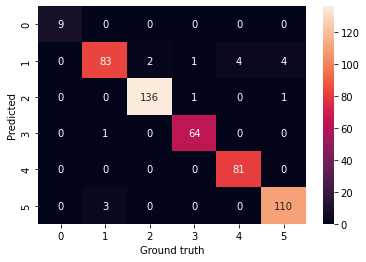

In [43]:
sns.heatmap(confusion_matrix(labels, predictions), annot = True, fmt = "g")
plt.ylabel("Predicted")
plt.xlabel("Ground truth")
plt.show()

In [36]:
for text, y_pred, y_truth in zip(tokenized_dataset["test"][0:10]["text"], predictions[0:10], labels[0:10]):
    print(f"{text} -- {y_pred} -- {y_truth}")

How far is it from Denver to Aspen ? -- 5 -- 5
What county is Modesto , California in ? -- 4 -- 4
Who was Galileo ? -- 3 -- 3
What is an atom ? -- 2 -- 2
When did Hawaii become a state ? -- 5 -- 5
How tall is the Sears Building ? -- 5 -- 5
George Bush purchased a small interest in which baseball team ? -- 3 -- 3
What is Australia 's national flower ? -- 1 -- 1
Why does the moon turn orange ? -- 2 -- 2
What is autism ? -- 2 -- 2


In [37]:
for i in range(len(predictions)):
    if predictions[i] != labels[i]:
        print(tokenized_dataset["test"][i]["text"])
        print(f"Predicted: {predictions[i]} - Label: {labels[i]}")

What is the proper name for a female walrus ?
Predicted: 3 - Label: 1
What is the speed hummingbirds fly ?
Predicted: 1 - Label: 5
What is the longest major league baseball-winning streak ?
Predicted: 5 - Label: 1
What is the major fault line near Kentucky ?
Predicted: 4 - Label: 1
What is the sales tax in Minnesota ?
Predicted: 5 - Label: 1
What is relative humidity ?
Predicted: 5 - Label: 2
What is the melting point of copper ?
Predicted: 1 - Label: 5
What are the spots on dominoes called ?
Predicted: 4 - Label: 1
What is the electrical output in Madrid , Spain ?
Predicted: 5 - Label: 1
What are the two houses of the Legislative branch ?
Predicted: 4 - Label: 1
What do meteorologists do ?
Predicted: 3 - Label: 2
What is the criterion for being legally blind ?
Predicted: 2 - Label: 1
What is foot and mouth disease ?
Predicted: 2 - Label: 1
What is the melting point of gold ?
Predicted: 1 - Label: 5
What monastery was raided by Vikings in the late eighth century ?
Predicted: 4 - Label:

In [38]:
wandb.finish()

eval/accuracy,▁▆▆▆▇▇▇█████████████████
eval/loss,█▂▂▂▁▂▂▁▁▁▁▂▂▂▁▂▁▂▁▁▂▂▁▁
eval/runtime,▁▁▁▂▁▂▂▂▂█▂▂▂▃▃▃▃▃▃▃▃▃▃▃
eval/samples_per_second,███▇▇▇▇▇▆▁▇▆▆▆▆▅▆▆▆▆▅▅▆▅
eval/steps_per_second,███▇▇▇▇▇▆▁▇▆▆▆▆▅▆▆▆▆▅▅▆▅
train/epoch,▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇█████
train/global_step,▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇█████
train/learning_rate,█▇▆▅▄▃▂▁
train/loss,█▃▂▂▁▁▁▁
train/total_flos,▁
train/train_loss,▁
